#### **Advanced Topics**

##### **Overview**
This notebook dives deeper and explore topics such as incorporating more realistic constraints and factors such as **turnover** and **transaction costs**. We will also explore potential use cases enabled by the massive acceleration.

##### **What You Will Learn**
1. **Examples of Rebalancing Strategies**:
   - **Percent Change Trigger**: Adjusting portfolios based on portfolio value fluctuations.
   - **Drift from Optimal Portfolio**: Managing weight deviations from the optimal allocation.
   - **Maximum Drawdown (MDD)**: Protecting capital by limiting downside risk.

2. **Incorporating Transaction Costs**:
   - Understanding **why frequent trading can erode returns**.
   - Optimizing portfolio changes **only when the benefits outweigh the costs**.

3. **Comparing Rebalancing Approaches**:
   - Evaluating **turnover constraints** and their impact on portfolio stability.
   - Using **GPU-accelerated optimization** for high-efficiency computations.

#### **Importing Required Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
# Import cuFOLIO and cuOpt
from cufolio import cvar_optimizer, cvar_utils, rebalance
from cuopt import linear_programming
from cuopt.linear_programming.solver_settings import PDLPSolverMode
from cuopt.linear_programming.solver.solver_parameters import *

#### **1. Instantiate Parameters and Optimizer Objects**

In this section, we define the parameters for Conditional Value-at-Risk (CVaR) optimization and initialize the optimizer.

##### 1.1 Define CVaR Parameters

The `CVaR_Parameters` object encapsulates key constraints and settings for portfolio optimization, ensuring risk-aware allocation.

**Parameters:**

- **Portfolio Constraints:**
  - `w_min`, `w_max`: Minimum and maximum asset weights.
  - `c_min`, `c_max`: Minimum and maximum cash holdings.
  - `L_tar`: Leverage constraint, representing the total long/short weight change in the portfolio.

- **Risk Constraints:**
  - `risk_aversion`: Controls the trade-off between return and risk (higher values prioritize lower risk).
  - `confidence`: Confidence level for CVaR estimation, representing the worse case lost on daily return.
  - `num_scen`: Number of simulated return scenarios.

- **Optional Constraints:**
  - `T_tar`: Turnover target, restricting how much the portfolio deviates from an existing allocation.
  - `cvar_limit`: Maximum allowed Conditional Value-at-Risk (CVaR).

- **Fitting Method:**
  - `fit_type`: Determines how return distributions are estimated:
    - `'kde'` (Kernel Density Estimation) for non-parametric return modeling.
    - `'no_fit'` to use historical return data directly.

In [2]:
# Define CVaR optimization parameters
cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,       # Minimum asset weight allocation
    w_max=0.8,        # Maximum asset weight allocation
    c_min=0,          # Minimum cash holdings
    c_max=0,          # Maximum cash holdings
    L_tar=1.6,        # Leverage constraint (total long/short weight change)
    T_tar=None,       # Turnover constraint (limits portfolio deviation from an existing allocation)
    cvar_limit=0.04,  # Maximum allowed Conditional Value-at-Risk (CVaR)
    risk_aversion=1,  # Change to risk aversion levels (0 = maximize return subject to risk constraints)
    confidence=0.95,  # Confidence level for CVaR calculation
    num_scen=10000,   # Number of return scenarios to simulate
    fit_type="kde",   # Return distribution estimation method ('kde' for kernel density estimation, 'no_fit' for historical returns)
)

In [3]:
# Select dataset and regime information
dataset_name = "sp500"
dataset_directory = f"../data/stock_data/{dataset_name}.csv"

# Define return type and regime period
"""
# If you want to analyze different market conditions, you can use the following predefined periods:
scenarios = {
    'pre_crisis': ('2005-01-01', '2007-10-01'),
    'crisis': ('2007-10-01', '2009-04-01'),
    'post_crisis': ('2009-06-30', '2014-06-30'),
    'oil_price_crash': ('2014-06-01', '2016-03-01'),
    'FAANG_surge': ('2015-01-01', '2021-01-01'),
    'covid': ('2020-01-01', '2023-01-01'),
    'recent': ('2022-01-01', '2024-07-01')
}
"""
return_type = "LOG"
in_sample_start_date = "2021-01-04"
in_sample_end_date = "2022-01-01"
regime_dict = {"name": "recent", "range": (in_sample_start_date, in_sample_end_date)}

# Compute returns dictionary (set device for KDE computation)
returns_dict = cvar_utils.calculate_returns(
    dataset_directory, regime_dict, return_type, cvar_params
)

# Instantiate CVaR optimization problem
example_cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict, cvar_params=cvar_params, problem_from_file=None
)

#### **2. Solve the Optimization Problem on GPU**

In [4]:
# specify the directory to save the files for cuOpt
folder_name = dataset_name + "-" + cvar_params.fit_type
file_name = regime_dict["name"] + "-num_scen" + str(cvar_params.num_scen)

# Initialize solver settings
gpu_settings = linear_programming.SolverSettings()
gpu_settings.set_parameter(CUOPT_PDLP_SOLVER_MODE, PDLPSolverMode.Stable2)
gpu_settings.set_optimality_tolerance(1e-4)                                # Define optimality tolerance (default: 1e-4)
gpu_settings.set_parameter(CUOPT_TIME_LIMIT, 10)                           # Set time limit for the solver to 10 seconds
gpu_settings.set_parameter(CUOPT_LOG_TO_CONSOLE, False)                    # Disable log to console

# Solve the optimization problem using the configured GPU solver settings
gpu_result, gpu_portfolio = example_cvar_problem.solve_optimization_problem(
    device="GPU", gpu_settings=gpu_settings
)

*************************
--- GPU CVaR Results---
recent: ('2021-01-04', '2022-01-01')
Scenarios: 10000
solver time: 0.0004 seconds
IO time: 0.5353 seconds
--- Optimal Portfolio ---
Long--AZO: 0.068
Long--BBWI: 0.005
Long--CPT: 0.05
Long--DVN: 0.157
Long--EXR: 0.367
Long--F: 0.142
Short--GPN: -0.148
Long--IRM: 0.038
Long--IT: 0.155
Short--LVS: -0.097
Long--NUE: 0.014
Long--NVDA: 0.022
Long--ON: 0.039
Long--PFE: 0.164
Long--PSA: 0.041
Short--ROL: -0.017
Long--TECH: 0.037
Short--TFX: -0.039
cash: 0.0
*************************



#### **3. Adding an Existing Portfolio: CVaR Optimization with Turnover Limit**

This script sets up and initializes an exisiting portfolio with turnover constraints. Turnover constraints limit how much an optimized portfolio can deviate from an existing portfolio. The mathematical program can be written as follows:

\begin{align*}
\text{Minimize: } & \mathbf{\mu}^\top \mathbf{w} - \lambda\left(t + \frac{1}{1-\alpha} \mathbf{p}^\top \mathbf{u}\right)\\
\text{Subject to: }
& \mathbf{u} + t \geq -\mathbf{R}^\top \mathbf{w},\\
& \mathbf{u} \geq \mathbf{0},\\
& \mathbf{1}^\top \mathbf{w} + c = 1, \mathbf{w}^{\min} \leq \mathbf{w} \leq \mathbf{w}^{\max}, c^{\min} \leq c \leq c^{\max},\\
&L := \lVert \mathbf{w} \rVert_1 \leq L^{limit},\\
&T := \lVert \mathbf{w} - \mathbf{w}_{pre}\rVert_1 \leq T^{limit}.
\end{align*}

In [5]:
# Define CVaR optimization parameters
cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,
    w_max=0.8,
    c_min=0.1,
    c_max=0.4,
    L_tar=1.6,
    T_tar=0.5,       # Turnover constraint (limits portfolio deviation from an existing allocation, which is sum of absolute wieght changes)
    cvar_limit=0.04,
    risk_aversion=1,
    confidence=0.95,
    num_scen=10000,
    fit_type="kde",
)

##### 3.2 Load Returns Data  

In [6]:
out_of_sample_end_date = "2024-01-01"
regime_dict = {
    "name": "recent",
    "range": (in_sample_start_date, out_of_sample_end_date),
}

# Compute returns dictionary (set device for KDE computation)
returns_dict = cvar_utils.calculate_returns(
    dataset_directory, regime_dict, return_type, cvar_params
)

##### 3.3 Initialize CVaR Optimization with Existing Portfolio
We now create a CVaR optimizer object using:
- The computed returns
- The defined risk constraints
- An existing portfolio (current_portfolio) for turnover constraints

In [7]:
# Existing portfolio setup
current_portfolio = gpu_portfolio  # Portfolio created in section 2

# Initialize CVaR optimization with turnover constraints
turnover_cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,             # Computed returns data
    cvar_params=cvar_params,               # Optimization settings
    problem_from_file=None,                # Set to JSON file if using a pre-defined problem
    existing_portfolio=current_portfolio,  # Incorporate existing portfolio
)

##### 3.4 Solving the CVaR Optimization Problem with Turnover Constraints

This section solves the CVaR optimization problem while considering turnover constraints and an existing portfolio. The optimization is executed on a GPU for enhanced computational efficiency.

In [8]:
# Solve the CVaR optimization problem with turnover constraints
turnover_result, turnover_portfolio = turnover_cvar_problem.solve_optimization_problem(
    device="GPU",               # Specify computation device (GPU for accelerated performance)
    gpu_settings=gpu_settings,  # Configuration settings for GPU execution
)

*************************
--- GPU CVaR Results---
recent: ('2021-01-04', '2024-01-01')
Scenarios: 10000
solver time: 0.0003 seconds
IO time: 0.3999 seconds
--- Optimal Portfolio ---
Long--AZO: 0.068
Long--BBWI: 0.005
Long--CPT: 0.05
Long--DVN: 0.157
Long--EXR: 0.233
Long--F: 0.133
Short--GPN: -0.148
Short--ILMN: -0.028
Long--IRM: 0.038
Long--IT: 0.155
Long--LLY: 0.05
Short--LVS: -0.097
Short--MTCH: -0.172
Long--NUE: 0.014
Long--NVDA: 0.022
Long--ON: 0.039
Long--PFE: 0.055
Long--PSA: 0.041
Short--ROL: -0.017
Long--TECH: 0.037
Short--TFX: -0.039
cash: 0.4
*************************



##### 3.5 Checking if Turnover Constraint is Bounded

This section verifies whether the turnover constraint is respected by comparing the sum of absolute weight changes against the predefined tracking error limit (`T_tar`).

In [9]:
# Check if the turnover constraint is met
error = cvar_params.T_tar - np.sum(np.abs(turnover_portfolio.weights - gpu_portfolio.weights))

# Print the error value (should be close to zero if the constraint is satisfied)
print(error)

-0.00020580646870704822


#### **4. Portfolio Rebalancing: Managing Risk and Performance**

Portfolio rebalancing is a crucial strategy in investment management that ensures a portfolio remains aligned with its target risk-return profile. To test the effectiveness of any strategy, it requires solving multiple optimization problems over an extended period of time. Thus, harnessing the power of accelerated GPU solutions, we will be able to perform test strategies much more efficiently. 

##### 4.1 Setting Up Portfolio Rebalancing with CVaR Constraints

This section defines the CVaR optimization parameters, sets up GPU solver configurations, and prepares a rebalancing framework.

In [10]:
# Define CVaR optimization parameters for rebalancing
cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,       # Minimum weight allocation per asset
    w_max=0.8,        # Maximum weight allocation per asset
    c_min=0.1,        # Minimum cash holdings
    c_max=0.4,        # Maximum cash holdings
    L_tar=1.6,        # Target leverage level
    T_tar=None,       # No explicit turnover constraint
    cvar_limit=0.02,  # Stricter CVaR risk limit for rebalancing
    risk_aversion=1,  # Adjust risk aversion level
    confidence=0.95,  # Confidence level for CVaR calculation
    num_scen=10000,   # Higher number of Monte Carlo scenarios for better accuracy
    fit_type="kde",   # Kernel Density Estimation for return distribution modeling
)

##### 4.2 Market Data & Trading Horizon

The dataset includes global equity market data, and the rebalancing strategy is tested over a rolling window framework:

In [11]:
# Dataset configuration
dataset_name = "global_titans_proxy"
dataset_directory = f"../data/stock_data/{dataset_name}.csv"

# Define trading period
trading_start = "2021-05-01"  # Portfolio rebalancing start date
trading_end = "2024-05-01"    # Portfolio rebalancing end date

# Look-back and look-forward windows for backtesting
look_back_window = 126        # Historical period used for optimization (days)
look_forward_window = 63      # Testing period (out-of-sample performance)
return_type = "LOG"           # Logarithmic returns for better risk modeling

##### 4.3 Configure cuOpt solver

In [12]:
# GPU Solver Settings
gpu_settings = linear_programming.SolverSettings()
gpu_settings.set_parameter(CUOPT_PDLP_SOLVER_MODE, PDLPSolverMode.Stable2)
gpu_settings.set_optimality_tolerance(1e-4)                                # Define optimality tolerance (default: 1e-4)
gpu_settings.set_parameter(CUOPT_TIME_LIMIT, 10)                           # Set time limit for the solver to 10 seconds
gpu_settings.set_parameter(CUOPT_LOG_TO_CONSOLE, False)                    # Disable log to console

# Package GPU configurations into a dictionary
gpu_configs = {"settings": gpu_settings}

#### **5. Portfolio Rebalancing Strategies**

Portfolio rebalancing is essential for maintaining risk control, optimizing returns, and adapting to market fluctuations. In this section, we explore three rebalancing strategies:
1. Percent Change of Portfolio Value – Triggers rebalancing when the portfolio value declines beyond a predefined threshold.
2. Drift from Optimal Portfolio – Adjusts holdings when asset weights significantly deviate from the target allocation.
3. Maximum Drawdown (MDD) – Rebalances the portfolio when the peak-to-trough decline exceeds a specified limit, helping mitigate large losses.

##### **Re-Optimization Strategy 1: Re-Optimizing Portfolio Based on Percent Change**

**Re-Optimization Criteria**

Rebalancing is triggered if either of the following conditions is met:
- The percent change in portfolio value from the start to the end of a testing period falls below `pct_change_tolerance`.
- The cumulative percent change since the **last positive** percent change period falls below `pct_change_tolerance`.

*****Testing No Re-Optimize*****
*****Testing Re-Optimize*****


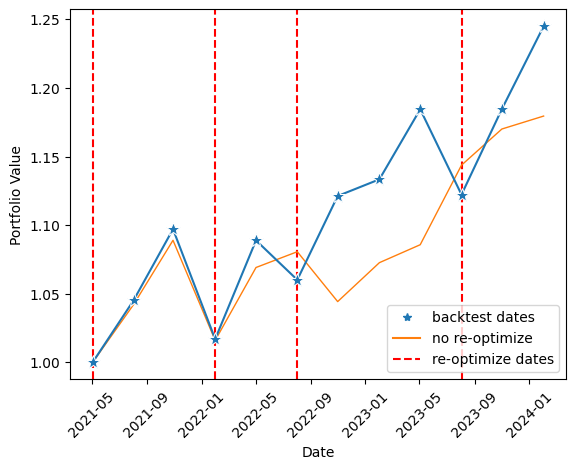

In [13]:
# Define re-optimization tolerance threshold
pct_change_tolerance = -0.005   # Trigger rebalancing if portfolio value drops by more than 0.5%

# Set re-optimization criteria
re_optimize_criteria = {"type": "pct_change", "threshold": pct_change_tolerance}

# Execute portfolio rebalancing with re-optimization conditions
rebalancing = rebalance.rebalance_portfolio(
    dataset_directory,          # Path to market data
    trading_start,              # Start date for backtesting
    trading_end,                # End date for backtesting
    look_forward_window,        # Testing period length (out-of-sample)
    look_back_window,           # Historical period used for optimization
    cvar_params,                # Optimization constraints
    gpu_configs,                # GPU solver settings
    re_optimize_criteria,       # Criteria for triggering re-optimization
    return_type,                # Type of returns (log returns in this case)
    print_opt_result=False,     # Set to True for detailed portfolio outputs
)

# Retrieve optimization results
results_dataframe, re_optimize_dates = rebalancing.re_optimize(plot_results=True)

##### **Re-Optimization Strategy 2: Drift from Optimal Portfolio**

Portfolio drift occurs when asset weights deviate from their original optimal allocation due to market fluctuations. This strategy re-optimizes the portfolio when the difference between the current and optimal weights exceeds a predefined tolerance threshold `drift_tolerance`.

**Rebalancing is triggered when:**

$$
\| w_{cur} - w_{opt} \| > tol
$$

where:
- $ w_{cur} $ = Current portfolio weights  
- $ w_{opt} $ = Optimal portfolio weights  
- $ tol $ = **Drift tolerance** (threshold for deviation)  
- **Norm type**: Either **1-norm** (absolute differences) or **2-norm** (Euclidean distance).


In [14]:
# Define drift tolerance threshold
drift_tolerance = 0.01        # Rebalancing is triggered when weight deviation exceeds 1%

# Set re-optimization criteria for drift
re_optimize_criteria = {
    "type": "drift_from_optimal",
    "threshold": drift_tolerance,
    "norm": 2,                # Using L2 norm for deviation measurement
}

# Execute portfolio rebalancing based on drift from optimal allocation
drift_rebalancing = rebalance.rebalance_portfolio(
    dataset_directory,        # Path to market data
    trading_start,            # Start date for backtesting
    trading_end,              # End date for backtesting
    look_forward_window,      # Testing period length (out-of-sample)
    look_back_window,         # Historical period used for optimization
    cvar_params,              # Optimization constraints
    gpu_configs,              # GPU solver settings
    re_optimize_criteria,     # Drift-based rebalancing criteria
    return_type,              # Type of returns (log returns)
    print_opt_result=False,   # Set to True for detailed output logs
)

*****Testing No Re-Optimize*****


*****Testing Re-Optimize*****


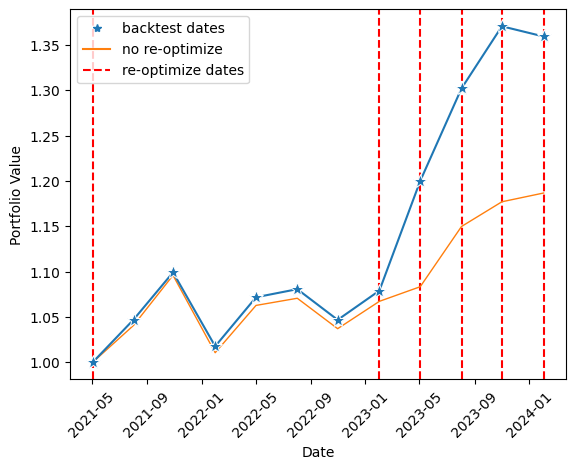

In [15]:
# Retrieve re-optimization results
drift_results_dataframe, drift_re_optimize_dates = drift_rebalancing.re_optimize(
    plot_results=True
)

##### **Re-Optimization Strategy 3: Maximum Drawdown (MDD)**

**Maximum Drawdown (MDD)** measures the **largest decline** from a portfolio's peak value to its lowest point before recovery. It quantifies **downside risk** and is defined as:

$$
\text{Max Drawdown} = \frac{\text{Peak} - \text{Trough}}{\text{Peak}}
$$

This strategy **re-optimizes** the portfolio if the **max drawdown over a backtest period exceeds** a predefined **tolerance threshold** (`max_drawdown_tolerance`).


*****Testing No Re-Optimize*****
*****Testing Re-Optimize*****


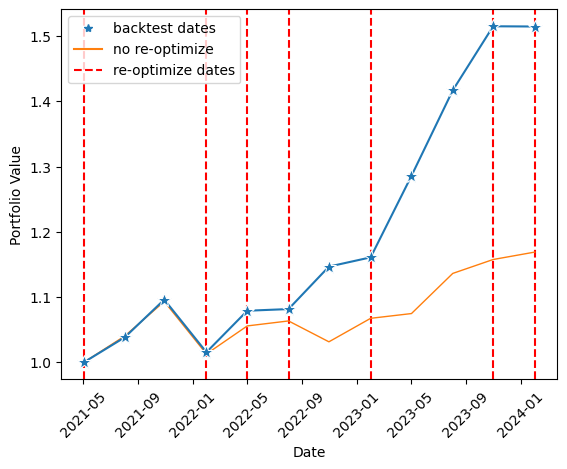

In [16]:
# Define max drawdown tolerance threshold
max_drawdown_tolerance = 0.05      # Rebalancing is triggered if portfolio drops more than 5% from peak

# Set re-optimization criteria for max drawdown
re_optimize_criteria = {"type": "max_drawdown", "threshold": max_drawdown_tolerance}

# Execute portfolio rebalancing based on max drawdown
mdd_rebalancing = rebalance.rebalance_portfolio(
    dataset_directory,             # Path to market data
    trading_start,                 # Start date for backtesting
    trading_end,                   # End date for backtesting
    look_forward_window,           # Testing period length (out-of-sample)
    look_back_window,              # Historical period used for optimization
    cvar_params,                   # Optimization constraints
    gpu_configs,                   # GPU solver settings
    re_optimize_criteria,          # Max drawdown-based rebalancing criteria
    return_type,                   # Type of returns (log returns)
    print_opt_result=False,        # Set to True for detailed output logs
)

# Retrieve re-optimization results
mdd_results_dataframe, mdd_re_optimize_dates = mdd_rebalancing.re_optimize(
    plot_results=True
)

#### **6. Rebalancing Portfolio with Transaction Costs**

In portfolio management, **rebalancing** is essential to maintaining the desired **risk-return profile**. However, frequent rebalancing can incur **significant transaction costs**, which erode returns over time. Incorporating **transaction costs into rebalancing decisions** ensures that adjustments are made **only when the benefits outweigh the costs**.

**Why Consider Transaction Costs?**
- **Minimizing Unnecessary Trades**: Avoids excessive trading, which can lead to higher fees.
- **Preserving Portfolio Value**: Reduces the impact of slippage and commissions on net returns.
- **Enhancing Long-Term Returns**: Ensures rebalancing is cost-effective, rather than reactive.

##### 6.1 Rebalancing Portfolio with Transaction Costs

This section implements **drift-based rebalancing** while accounting for transaction costs.

In [17]:
# Define CVaR parameters with turnover constraints
cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,       # Minimum weight allocation per asset
    w_max=0.8,        # Maximum weight allocation per asset
    c_min=0.1,        # Minimum cash holdings
    c_max=0.4,        # Maximum cash holdings
    L_tar=1.6,        # Target leverage level
    T_tar=0.5,        # Turnover constraint
    cvar_limit=0.02,  # CVaR risk limit
    risk_aversion=1,  # Adjust risk aversion level
    confidence=0.95,  # Confidence level for CVaR calculation
    num_scen=10000,   # Number of Monte Carlo scenarios
    fit_type="kde",   # Return distribution modeling method
)

# Dataset configuration
dataset_name = "global_titans_proxy"
dataset_directory = f"../data/stock_data/{dataset_name}.csv"

# Define trading period
trading_start = "2021-05-01"
trading_end = "2024-05-01"

# Look-back and look-forward windows
look_back_window = 126
look_forward_window = 63
return_type = "LOG"

# GPU Solver Settings
gpu_settings = linear_programming.SolverSettings()
gpu_settings.set_parameter(CUOPT_PDLP_SOLVER_MODE, PDLPSolverMode.Stable2)
gpu_settings.set_optimality_tolerance(1e-4)                                # Define optimality tolerance (default: 1e-4)
gpu_settings.set_parameter(CUOPT_TIME_LIMIT, 10)                           # Set time limit for the solver to 10 seconds
gpu_settings.set_parameter(CUOPT_LOG_TO_CONSOLE, False)                    # Disable log to console

# Package GPU configurations
gpu_configs = {"settings": gpu_settings}

*****Testing No Re-Optimize*****
No existing portfolio: no turnover constraint imposed.
*****Testing Re-Optimize*****
No existing portfolio: no turnover constraint imposed.


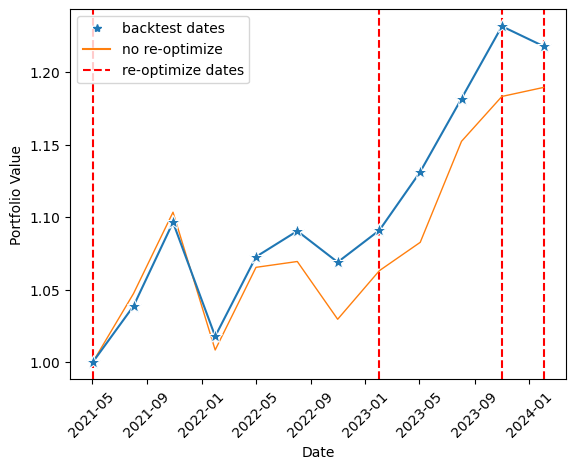

In [18]:
# Define rebalancing criteria with drift threshold and transaction costs
drift_tolerance = 0.01
transaction_cost_factor = 0.005   # Cost per trade

re_optimize_criteria = {
    "type": "drift_from_optimal",
    "threshold": drift_tolerance,
    "norm": 2,                    # L2 norm for deviation measurement
}

# Perform rebalancing with transaction cost consideration
tc_drift_rebalancing = rebalance.rebalance_portfolio(
    dataset_directory,
    trading_start,
    trading_end,
    look_forward_window,
    look_back_window,
    cvar_params,
    gpu_configs,
    re_optimize_criteria,
    return_type,
    print_opt_result=False,
)

# Retrieve results
tc_drift_results_dataframe, tc_drift_re_optimize_dates = (
    tc_drift_rebalancing.re_optimize(
        plot_results=True, transaction_cost_factor=transaction_cost_factor
    )
)

##### 6.2 Comparing with No Turnover Constraint
To evaluate the impact of turnover constraints, we compare against a model without turnover limits.

*****Testing No Re-Optimize*****
*****Testing Re-Optimize*****


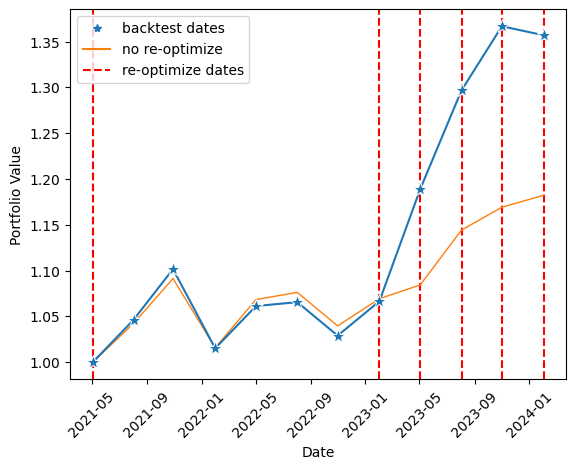

In [19]:
# Define CVaR parameters without turnover constraints
no_turnover_cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3,
    w_max=0.8,
    c_min=0.1,
    c_max=0.4,
    L_tar=1.6,
    T_tar=None,      # No turnover constraint
    cvar_limit=0.02,
    risk_aversion=1,
    confidence=0.95,
    num_scen=10000,
    fit_type="kde",
)

# Perform rebalancing without turnover constraint
drift_tolerance = 0.01
re_optimize_criteria = {
    "type": "drift_from_optimal",
    "threshold": drift_tolerance,
    "norm": 2,
}

drift_rebalancing = rebalance.rebalance_portfolio(
    dataset_directory,
    trading_start,
    trading_end,
    look_forward_window,
    look_back_window,
    no_turnover_cvar_params,
    gpu_configs,
    re_optimize_criteria,
    return_type,
    print_opt_result=False,
)

# Retrieve results
drift_results_dataframe, drift_re_optimize_dates = drift_rebalancing.re_optimize(
    plot_results=True, transaction_cost_factor=transaction_cost_factor
)

SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.